In [220]:
import numpy as np
from numpy.linalg import inv
Pi = np.pi
sqrt = np.sqrt
sin = np.sin
cos = np.cos

In [19]:
def rpFluidModulus(K1, K2, s1, q):
    return((q*(1 - s1) + s1)/((q*(1 - s1))/K2 + s1/K1))
def rpBrooksCorey(l, sw, snw,s):
    def seff(s):
        return(np.clip((s-sw)/(1-sw-snw),0,1))
    def kw(s):
        return(np.clip(seff(s)**((2+3*l)/l),0,1))
    def knw(s):
        return(np.clip(((1-seff(s))**2*(1-seff(s)**((2+l)/l))),0,1))
    return([kw(s),knw(s)])
def rpViscosityMix(h1, h2, q, l, sw, snw,s):
    k = rpBrooksCorey(l, sw, snw,s)
    return((s + q*(1 - s))/(k[0]/h1 + q*(k[1]/h2)))
def rpFreqMix(h1, h2, q, l, sw, snw,s):
    return(h1/rpViscosityMix(h1, h2, q, l, sw, snw,s))

In [208]:
def rpGassmannModel(Kd, mu, Km, phi, Kf):
    return(Kd + (1 - Kd/Km)**2/(phi/Kf - Kd/Km**2 + (1 - phi)/Km))
def rpSquirtModel(Kd, mu, Km, phi, Kf, ee, aspectRatio, tau, w, eta):
    fc = (4.*aspectRatio*Pi*ee)/3.
    fp = phi - fc
    m = -(16*Km**2*fc +3*aspectRatio*Km*Pi*(4*Kd + Km*(-4 + 5*fp)) + 
          sqrt(Km**2*(256*Km**2*fc**2 + 9*aspectRatio**2*Pi**2*
                      (4*Kd - 4*Km + 3*Km*fp)**2 + 
                      96*aspectRatio*Km*Pi*fc*(2*Kd - 2*Km + 3*Km*fp))))/(8.*aspectRatio*Pi*(Kd + Km*(-1 + fp)))
    nu = (3*Km - 2*m)/(2.*(3*Km + m))
    sc =(aspectRatio*m*Pi)/(2.*(1 - (3*Km - 2*m)/(2.*(3.*Km + m))))
    Kc = sc/Kf
    Kp = (4*m)/(3*Kf)
    gam = (3*aspectRatio*fp*(1 + Kp)*Pi)/(8.*fc*(1 + Kc)*(1 - (3*Km - 2*m)/(2.*(3*Km + m))))
    gam2 = (3*Km*gam + 4*m*gam)/(9*Km + 9*Km*Kp)
    mhf =(4*fc*m*((2*(1 - (3*Km - 2*m)/(2.*(3*Km + m))))/(aspectRatio*Pi) + (6 - 6*nu)/(2*aspectRatio*Pi - aspectRatio*nu*Pi) - 
                  (6*(-1 + nu)*(1j*m + eta*w))/(-2*eta*(-1 + nu)*w + aspectRatio*(-2 + nu)*Pi*(1j*m + eta*w)) - 
                  (2*(1 - (3*Km - 2*m)/(2.*(3*Km + m)))* (Kc + 1/(1 + 1j*tau*w)))/(aspectRatio*(1 + Kc)*Pi)))/15.
    Klf = Kd + \
        fp*(Km*((1 + (3*Km)/(4.*m)) + \
        fc*(1 + (2*Km*(1 - (3*Km - 2*m)/(2.*(3*Km + m))))/(aspectRatio*m*Pi)))*(1 + 3*(1 + Kc)*gam2))/((1 + Kc)*(1 + gam))
    Khf = fp*((gam - 3*gam2*(1 + Kc))*Km*(-((1 + (3*Km)/(4.*m))) + \
        fc*gam*(1 + (2*Km*(1 - (3*Km - 2*m)/(2.*(3*Km + m))))/(aspectRatio*m*Pi))))/(gam*(1 +\
        gam)*(1 + Kc)*(1 - (1j*(1 + gam))/(gam*tau*w)))
    return([Klf+Khf, mu+mhf])

In [206]:
def rpAnisSquirtModel(lam, m, f, Kf, ee, eef, aspectRatio, tau, w, ratio):
    fc = (4.*aspectRatio*Pi*ee)/3.
    ff = (4.*aspectRatio*Pi*eef)/3.
    fp = f - fc - ff
    nu = lam/(2.*(lam + m))
    sc =(aspectRatio*m*Pi)/(2.*(1 - nu))
    Kc = sc/Kf
    Kp = (4*m)/(3*Kf)
    gam = (3*fp*(1 + Kp)*sc)/(4.*fc*(1 + Kc)*m)
    gam2 = (gam*(1 - nu))/((1 + Kp)*(1 + nu))
    io = fc/(fc + aspectRatio*fp)
    bet = io*ff/fc
    tauf = ratio*tau
    D1 = (io*(-1j - bet*tau*w + tauf*w) + 3*gam2*(1 + Kc)*(io*(1j + bet*tau*w - tauf*w) + \
        (-1j + tau*w)*(1 + 1j*tauf*w)))/(3.*(1 + Kc)*(bet*(-1j + (1 + (-1 + gam)*io)*tau*w) - \
        (-1j + tauf*w)*(-io + gam*(-1 + io - 1j*tau*w))))
    D2 =  (bet*(-1j + tau*w))/((1 + Kc)*(bet*(-1j + \
        (1 + (-1 + gam)*io)*tau*w) -(-1j + tauf*w)*(-io + gam*(-1 + io - 1j*tau*w))))
    G1 = (tau*w)/((1 + Kc)*(-1j + tau*w))
    G2 = (1j/3*(1j + bet*tau*w - tauf*w)*(io + 1j*gam*io*tau*w - \
        3*1j*gam2*(-1 + io)*(1 + Kc)*(-1j + tau*w)))/((1 + Kc)*\
        (-1j + tau*w)*(bet*(-1j + (1 + (-1 + gam)*io)*tau*w) - \
        (-1j + tauf*w)*(-io + gam*(-1 + io - 1j*tau*w))))
    G3 = (bet*(-1j + gam*tau*w))/((1 + Kc)*(bet*(-1j + (1 + (-1 + gam)*io)*tau*w) - \
        (-1j + tauf*w)*(-io + gam*(-1 + io - 1j*tau*w))))
    F1 = (-3*gam2*(-1 + io)*(1 + Kc)*(-1j + tau*w) + \
        io*(-1j + gam*tau*w))/(3.*(1 + Kc)*(bet*(-1j + (1 + (-1 + gam)*io)*tau*w) - \
        (-1j + tauf*w)*(-io + gam*(-1 + io - 1j*tau*w))))
    F2 = (tauf*w*(gam + io - gam*io + 1j*gam*tau*w) + \
        bet*(-1j + (1 + (-1 + gam)*io)*tau*w))/((1 + Kc)*(bet*(-1j + (1 + (-1 + gam)*io)*tau*w) - \
        (-1j + tauf*w)*(-io + gam*(-1 + io - 1j*tau*w))))
    k = lam + (2*m)/3.
    L2 = k**2 + (16*m**2)/45.
    L4 = k**2 - (8*m**2)/45.
    c11 = lam + 2*m - \
        fp*(-((3*D1*k + D2*lam)*(1 + (3*k)/(4.*m))) + \
            (3*(1 - nu)*(3*lam**2 + 4*lam*m + (m**2*(36 + 20*nu))/(7 - 5*nu)))/(4.*m*(1 + nu))) - \
        fc*((32*m*(1 - nu))/(15.*aspectRatio*(2 - nu)*Pi) - \
            G2*(3*k + (3*k**2)/sc) - G1*(k + L2/sc) - G3*(lam + (k*lam)/sc) + L2/sc) - \
        ff*(-3*F1*k*(1 + lam/sc) - F2*lam*(1 + lam/sc) + lam**2/sc)
    c33 = lam + 2*m - \
        fp*(-((1 + (3*k)/(4.*m))*(3*D1*k + D2*(lam + 2*m))) + \
            (3*(1 - nu)*(3*lam**2 + 4*lam*m + (m**2*(36 + 20*nu))/(7 - 5*nu)))/(4.*m*(1 + nu))) - \
        fc*((32*m*(1 - nu))/(15.*aspectRatio*(2 - nu)*Pi) - \
            G2*(3*k + (3*k**2)/sc) - G1*(k + L2/sc) - G3*(lam + 2*m + (k*(lam + 2*m))/sc) + L2/sc) - \
        ff*(-3*F1*k*(1 + (lam + 2*m)/sc) -  F2*(lam + 2*m)*(1 + (lam + 2*m)/sc) + (lam + 2*m)**2/sc)
    c44 = m - \
        fp*(15*m*(1 - nu))/(7 - 5*nu) - \
        fc*((8*m*(1 - nu))/(5.*aspectRatio*(2 - nu)*Pi) + (4*(1 - G1)*m**2)/(15.*sc)) - \
        ff*(4*m*(1 - nu))/(aspectRatio*(2 - nu)*Pi)
    c12 = lam - \
        fp*(-((3*D1*k + D2*lam)*(1 + (3*k)/(4.*m))) + \
            (3*(1 - nu)*(3*lam**2 + 4*lam*m - (4*m**2*(1 + 5*nu))/(7 - 5*nu)))/(4.*m*(1 + nu))) - \
        fc*((-16*m*(1 - nu))/(15.*aspectRatio*(2 - nu)*Pi) - \
            G2*(3*k + (3*k**2)/sc) - G1*(k + L4/sc) - G3*(lam + (k*lam)/sc) + L4/sc) - \
        ff*(-3*F1*k*(1 + lam/sc) - F2*lam*(1 + lam/sc) + lam**2/sc)
    c13 = lam - \
        fp*(-((1 + (3*k)/(4.*m))*(3*D1*k + D2*(lam + m))) + \
            (3*(1 - nu)*(3*lam**2 + 4*lam*m - (4*m**2*(1 + 5*nu))/(7 - 5*nu)))/(4.*m*(1 + nu))) - \
        fc*((-16*m*(1 - nu))/(15.*aspectRatio*(2 - nu)*Pi) - \
            G2*(3*k + (3*k**2)/sc) - G1*(k + L4/sc) - G3*(lam + m + (k*(lam + m))/sc) + L4/sc) - \
        ff*(-3*F1*k*(1 + (lam + m)/sc) - F2*(lam + m + (lam*(lam + 2*m))/sc) + (lam*(lam + 2*m))/sc)
    return([c11, c13, c33, c44, c12])

In [217]:
def rpAnisHTIVelocities(c11, c33, c44, c12, c13, rho, theta):
    # Vs1, Vs2 add
    H = 4*(c13 + c44)**2*cos(theta)**2*sin(theta)**2 + (-((c33 - c44)*cos(theta)**2) + (c11 - c44)*sin(theta)**2)**2
    Vp = sqrt((c11*sin(theta)**2 + c33*cos(theta)**2+c44 +sqrt(H))/(2*rho))
    return(Vp)

In [221]:
[c11, c33, c44, c12, c13]=rpAnisSquirtModel(1,2,.3,1,.01,.03,.00001,1,1,10)
rho=10
theta = 0
rpAnisHTIVelocities(c11, c33, c44, c12, c13, rho, theta)

(0.5278547112130603+0.007030949896490306j)

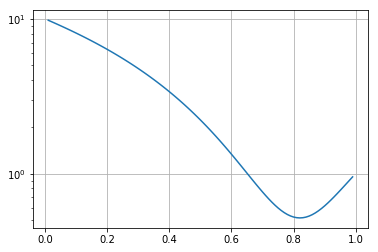

In [223]:
fig, ax = plt.subplots()

dt = 0.01
t = np.arange(dt, 1.0, dt)

ax.semilogy(t, rpFreqMix(10, 1, 1, 1, 0, 0, t))
ax.grid()

plt.show()